# Importing Libraries

In [ ]:
import pandas
import torch
import torch.nn as nn
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

# Loading The dataset

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor() ,

    transforms.Normalize((0.5  , 0.5 , 0.5) , (0.5  , 0.5 , 0.5)) # Helps to normalize the data and make it zero centered

])
transform_test = transforms.Compose([
    transforms.ToTensor() ,

    transforms.Normalize((0.5  , 0.5 , 0.5) , (0.5  , 0.5 , 0.5))
])

In [ ]:
full_train = CIFAR10(root="./data" , train=True , download=True , transform = transform_train)
test = CIFAR10(root="./data" , train=False , download=True , transform = transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
print(f"Training set size: {len(full_train)}")
print(f"Test set size: {len(test)}")

Training set size: 50000
Test set size: 10000


In [ ]:
# Splitting test into test and validation
test_size = len(test) // 2
val_size  = len(test) - test_size


test_set , val_set = torch.utils.data.random_split(test , [test_size , val_size])


In [ ]:
print(f"Test Set Size : {len(test_set)}")
print(f"Validation Set Size : {len(val_set)}")

Test Set Size : 5000
Validation Set Size : 5000


In [ ]:
train_loader = torch.utils.data.DataLoader(full_train , batch_size = 32 , shuffle = True )
val_loader = torch.utils.data.DataLoader(val_set, batch_size= 32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size= 32, shuffle=False)


# Building Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:

class CNN(nn.Module):

  def __init__(self):
    super(CNN , self).__init__()

    self.conv = nn.Sequential(
      nn.Conv2d(in_channels = 3 , out_channels= 32 , kernel_size= 3 , padding = 1),
      nn.ReLU(),
      nn.BatchNorm2d(32),
      nn.MaxPool2d(2 , 2),

      nn.Conv2d(in_channels = 32 , out_channels= 64 , kernel_size= 3 , padding = 1),
      nn.ReLU(),
      nn.BatchNorm2d(64),
      nn.MaxPool2d(2 , 2),

      nn.Conv2d(in_channels = 64 , out_channels= 128 , kernel_size= 3  , padding = 1),
      nn.ReLU(),
      nn.BatchNorm2d(128),
      nn.MaxPool2d(2 , 2),



    )


    self.fc_layer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(128 * 4 * 4  , 512),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(512 , 128),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(128 , 10)

    )

  def forward(self , X):
    X = self.conv(X)
    #print(X.shape)
    X = self.fc_layer(X)
    return X


  def evaluate(self , model , val_loader , criterion):
    model.eval()

    correct , total = 0 , 0
    total_loss = 0.0

    with torch.no_grad():
      for images , label in val_loader:
        images , label = images.to(device) , label.to(device)

        outputs = model(images)

        loss = criterion(outputs , label)
        total_loss += loss.item()

        _ , predicted = outputs.max(1)

        total += label.size(0)
        correct += predicted.eq(label).sum().item()

    loss = total_loss / total
    val_acc = (correct / total) * 100

    return loss , val_acc





  def train_model(self, train_loader , model , val_loader , criterion , optimizer , epochs):
    self.train_loss_list = []
    self.train_acc_list = []

    self.val_loss_list = []
    self.val_acc_list = []

    model.train()
    for epoch in range(epochs) :

      print("##"  * 40)
      print(f"Starting Epoch : {epoch+1}/{epochs}")
      running_loss = 0.0
      correct , total = 0 , 0

      for images , labels in tqdm(train_loader , desc = "batch"):

        images , labels = images.to(device) ,labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs , labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _ , predicted = outputs.max(1)

        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

      train_acc = (correct / total) * 100
      train_loss = running_loss / total

      self.train_loss_list.append(train_loss)
      self.train_acc_list.append(train_acc)

      val_loss , val_acc = self.evaluate(model , val_loader , criterion)

      self.val_loss_list.append(val_loss)
      self.val_acc_list.append(val_acc)

      print(f"Epoch {epoch + 1}/{epochs}\nTrain Accuracy : {train_acc}\nTrain Loss : {train_loss}\nValidation Accuracy : {val_acc}\nValidation Loss : {val_loss}" )
      print("\n\n")

  def plot(self):
    epochs = range(1, len(self.train_loss_list) + 1)

    # Create a figure with 2 subplots (1 row, 2 columns)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot Loss
    axes[0].plot(epochs, self.train_loss_list, 'bo-', label='Training Loss')
    axes[0].plot(epochs, self.val_loss_list, 'r*-', label='Validation Loss')
    axes[0].set_title('Loss over Epochs')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid()

    # Plot Accuracy
    axes[1].plot(epochs, self.train_acc_list, 'bo-', label='Training Accuracy')
    axes[1].plot(epochs, self.val_acc_list, 'r*-', label='Validation Accuracy')
    axes[1].set_title('Accuracy over Epochs')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].legend()
    axes[1].grid()
    plt.savefig("test_loss.png")
    # Display the plots
    plt.tight_layout()
    plt.show()
















# Training model

In [ ]:
model = CNN()
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters() , lr = 0.001 , weight_decay=1e-4)

In [104]:
model.train_model(train_loader=train_loader ,model =  model  , val_loader=val_loader , criterion=criterion , optimizer=optimizer , epochs = 15 )

################################################################################
Starting Epoch : 1/15


batch: 100%|██████████| 1563/1563 [00:29<00:00, 53.58it/s]


Epoch 1/15
Train Accuracy : 65.212
Train Loss : 0.032043383836746216
Validation Accuracy : 71.88
Validation Loss : 0.02585029383301735



################################################################################
Starting Epoch : 2/15


batch: 100%|██████████| 1563/1563 [00:24<00:00, 64.18it/s]


Epoch 2/15
Train Accuracy : 72.158
Train Loss : 0.024972493735551833
Validation Accuracy : 75.44
Validation Loss : 0.02244915598630905



################################################################################
Starting Epoch : 3/15


batch: 100%|██████████| 1563/1563 [00:24<00:00, 62.88it/s]


Epoch 3/15
Train Accuracy : 74.36399999999999
Train Loss : 0.023074874596595765
Validation Accuracy : 73.78
Validation Loss : 0.024089424458146096



################################################################################
Starting Epoch : 4/15


batch: 100%|██████████| 1563/1563 [00:24<00:00, 63.07it/s]


Epoch 4/15
Train Accuracy : 76.094
Train Loss : 0.02157514723688364
Validation Accuracy : 77.72
Validation Loss : 0.02040726734995842



################################################################################
Starting Epoch : 5/15


batch: 100%|██████████| 1563/1563 [00:24<00:00, 63.36it/s]


Epoch 5/15
Train Accuracy : 77.448
Train Loss : 0.020275936557948588
Validation Accuracy : 77.53999999999999
Validation Loss : 0.020510603898763656



################################################################################
Starting Epoch : 6/15


batch: 100%|██████████| 1563/1563 [00:24<00:00, 62.98it/s]


Epoch 6/15
Train Accuracy : 78.306
Train Loss : 0.019638142218589782
Validation Accuracy : 78.18
Validation Loss : 0.020512705016136168



################################################################################
Starting Epoch : 7/15


batch: 100%|██████████| 1563/1563 [00:24<00:00, 63.33it/s]


Epoch 7/15
Train Accuracy : 78.84
Train Loss : 0.019029468840658665
Validation Accuracy : 78.66
Validation Loss : 0.019556792244315148



################################################################################
Starting Epoch : 8/15


batch: 100%|██████████| 1563/1563 [00:24<00:00, 63.46it/s]


Epoch 8/15
Train Accuracy : 79.758
Train Loss : 0.018298888785392046
Validation Accuracy : 78.62
Validation Loss : 0.019773545229434968



################################################################################
Starting Epoch : 9/15


batch: 100%|██████████| 1563/1563 [00:24<00:00, 63.18it/s]


Epoch 9/15
Train Accuracy : 80.34599999999999
Train Loss : 0.017746998037695885
Validation Accuracy : 79.38
Validation Loss : 0.019542762181162833



################################################################################
Starting Epoch : 10/15


batch: 100%|██████████| 1563/1563 [00:24<00:00, 63.56it/s]


Epoch 10/15
Train Accuracy : 81.128
Train Loss : 0.01704611843585968
Validation Accuracy : 78.4
Validation Loss : 0.02015093818306923



################################################################################
Starting Epoch : 11/15


batch: 100%|██████████| 1563/1563 [00:24<00:00, 63.05it/s]


Epoch 11/15
Train Accuracy : 81.744
Train Loss : 0.016604186299145222
Validation Accuracy : 80.30000000000001
Validation Loss : 0.018689490470290185



################################################################################
Starting Epoch : 12/15


batch: 100%|██████████| 1563/1563 [00:24<00:00, 63.37it/s]


Epoch 12/15
Train Accuracy : 81.874
Train Loss : 0.016406080333590506
Validation Accuracy : 81.10000000000001
Validation Loss : 0.017895257188379764



################################################################################
Starting Epoch : 13/15


batch: 100%|██████████| 1563/1563 [00:24<00:00, 63.27it/s]


Epoch 13/15
Train Accuracy : 82.48
Train Loss : 0.01592827930599451
Validation Accuracy : 80.4
Validation Loss : 0.017904748713970183



################################################################################
Starting Epoch : 14/15


batch: 100%|██████████| 1563/1563 [00:24<00:00, 63.34it/s]


Epoch 14/15
Train Accuracy : 83.03399999999999
Train Loss : 0.015515397671461106
Validation Accuracy : 80.74
Validation Loss : 0.01778881981819868



################################################################################
Starting Epoch : 15/15


batch: 100%|██████████| 1563/1563 [00:24<00:00, 62.75it/s]


Epoch 15/15
Train Accuracy : 82.918
Train Loss : 0.01526383649095893
Validation Accuracy : 81.86
Validation Loss : 0.017372085189819336





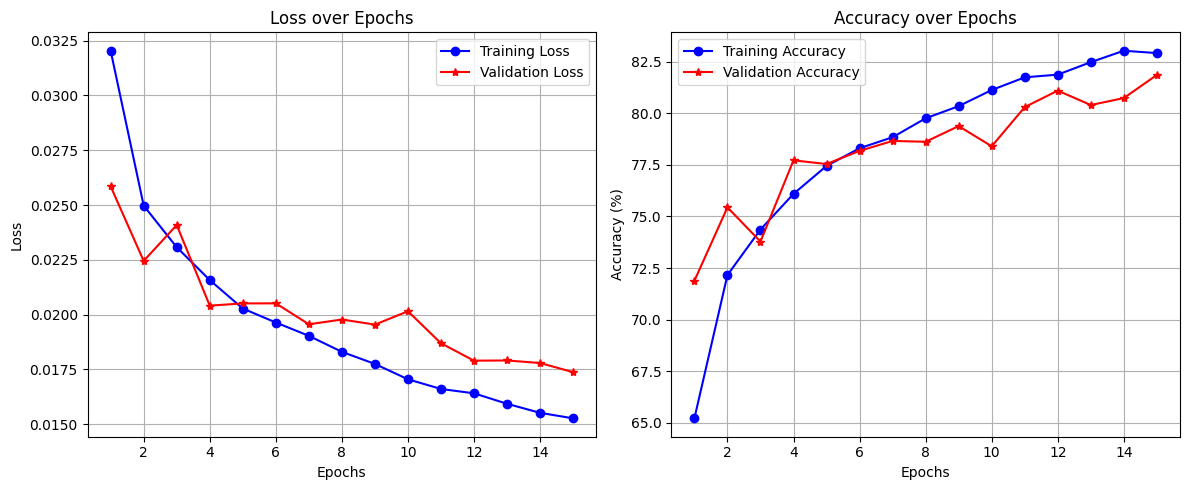

In [105]:
model.plot()

In [106]:
print(f"Test accuracy is : {model.evaluate(model , test_loader , criterion)[1]}")

Test accuracy is : 82.39999999999999
